# Context Confusion: Finding the Right Balance for Production Agents

Context confusion is a **real production problem** affecting agents today.

## The Problem

With MCP making it easy to connect dozens of services, agents can access more tools than ever. But the Berkeley Function-Calling Leaderboard shows a concerning pattern: **every model performs worse when provided with more tools**.

**Context Confusion Definition:** Superfluous content in the context from excessive tools, verbose instructions, or irrelevant information leads to low-quality responses.

The goal is to strike the right balance between capability and clarity. Too few tools limits what your agent can do. Too many tools, or poorly organized context, degrades performance.

## What We'll Explore

In this notebook, we'll use a shipping support agent to:
1. **Identify** how tool bloat, instruction overload, and irrelevant context degrade performance
2. **Measure** the impact using LangSmith evaluations at each problem step
3. **Solve** with three strategies: consolidation, smart routing, and pruning
4. **Validate** improvements LangSmith experiments

The goal: Build agents that are both capable and effective by optimizing what goes into the context.

## Three Problems We'll Solve

Using LangSmith evaluations, we'll diagnose and fix:

**Problem 1: Overloaded tools** - Too many tools degrades quality and model decision making 

**Problem 2: Irrelevant Noise** - Unrelated tools distract the model, even with moderate tool counts

**Problem 3: Instruction Bloat** - Verbose, multi-domain instructions reduce focus and accuracy


## Setup


In [1]:
# Imports
import os
from typing import List, Dict, Any, Literal
from langchain.agents import create_agent
from langsmith import Client, evaluate, traceable
from langsmith.schemas import Run, Example
from langchain_anthropic import ChatAnthropic
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import display, HTML
import pandas as pd
from langchain_openai import ChatOpenAI
from typing import TypedDict, Annotated
from dotenv import load_dotenv
import os
from openevals.llm import create_llm_as_judge
from openevals.prompts import CORRECTNESS_PROMPT

load_dotenv()

# Our shipping support agent tools
from context_confusion.tools import (
    shipping_core_tools,
    carrier_tools, 
    returns_tools,
    warehouse_tools,
    order_modification_tools,
    customer_service_tools,
    billing_tools,
    fraud_tools,
    analytics_tools,
    marketing_tools,
    vendor_tools,
    employee_tools,
    quality_tools,
    all_tools,
)
from context_confusion.instructions import (
    SHIPPING_SUPPORT_INSTRUCTIONS
)
from context_confusion.additional_context import IRRELEVANT_INSTRUCTIONS

# Initialize LangSmith
client = Client()

print("✓ Setup complete")

✓ Setup complete


In [2]:
# Initialize LLM - using 2025 Haiku for context confusion demo
llm = ChatAnthropic(model="claude-haiku-4-5-20251001", temperature=0)

print(f"Using model: {llm.model}")


Using model: claude-haiku-4-5-20251001


## The Production Agent: Capable but Struggling

Meet our shipping support agent. Over time, we've added tools for every domain:
- Core shipping operations (orders, tracking, shipments)
- Returns and customer service
- Warehouse and inventory management
- Billing and fraud detection
- Analytics and reporting
- Marketing, vendor management, employee ops...

**Total: ~75 tools across 18 domains**

The agent can theoretically handle any shipping-related query. But something's wrong with production performance - context confusion from too many overlapping tool choices.


In [3]:
# Create production agent with all ~75 tools
print("system prompt: ", SHIPPING_SUPPORT_INSTRUCTIONS)

production_agent = create_agent(
    model=llm,
    tools=all_tools,
    system_prompt=SHIPPING_SUPPORT_INSTRUCTIONS
)


print(f"Production agent: {len(all_tools)} tools available")
print("This represents a realistic 'kitchen sink' approach where all capabilities are exposed.")
print("Includes confusing near-duplicates that cause tool selection ambiguity.")


system prompt:  You are a helpful shipping support agent. 
Use the available tools to answer customer questions about orders, tracking, returns, and shipping.

Key guidelines:
- Always verify customer identity before sharing order details
- Check for carrier incidents if there are delivery delays
- Provide clear, accurate information based on the tools available

Current date: December 19, 2025
Production agent: 75 tools available
This represents a realistic 'kitchen sink' approach where all capabilities are exposed.
Includes confusing near-duplicates that cause tool selection ambiguity.


### Test Dataset

10 realistic queries covering common shipping support scenarios:


In [16]:
# Test dataset
test_cases = [
    # === Simple queries that should work with any reasonable setup ===
    {
        "query": "What's the status of order #84721?",
        "final_response": "Order #84721 is currently in transit.",
        "trajectory": [
            {"tool": "get_order", "args": {"order_id": "84721"}}
        ]
    },
    {
        "query": "Has my order #99002 been delivered yet?",
        "final_response": "Yes, order #99002 has been delivered successfully.",
        "trajectory": [
            {"tool": "get_order", "args": {"order_id": "99002"}}
        ]
    },
    {
        "query": "When will order #98765 arrive?",
        "final_response": "Order #98765 is estimated to arrive on March 20, 2024.",
        "trajectory": [
            {"tool": "get_order", "args": {"order_id": "98765"}},
            {"tool": "get_shipment", "args": {"order_id": "98765"}}
        ]
    },
    {
        "query": "Where is order #12345 right now?",
        "final_response": "Order #12345 was last scanned at the Atlanta distribution center.",
        "trajectory": [
            {"tool": "get_order", "args": {"order_id": "12345"}},
            {"tool": "get_tracking_details", "args": {"tracking_number": "1Z999AA10123456784"}}
        ]
    },
    {
        "query": "Why is my order #23456 delayed?",
        "final_response": "Order #23456 is delayed due to customs processing. It should clear customs soon and continue to its destination.",
        "trajectory": [
            {"tool": "get_order", "args": {"order_id": "23456"}},
            {"tool": "get_shipment", "args": {"order_id": "23456"}}
        ]
    },
    {
        "query": "Can you track order #84721?",
        "final_response": "Order #84721 has tracking number 1Z999AA10123456784 and is in transit.",
        "trajectory": [
            {"tool": "get_order", "args": {"order_id": "84721"}},
            {"tool": "get_tracking_details", "args": {"tracking_number": "1Z999AA10123456784"}}
        ]
    },
    
    # === Queries requiring additional capabilities ===
    {
        "query": "I'm user@example.com - what are my delivery preferences?",
        "final_response": "Your delivery instructions are to leave packages at the front door.",
        "trajectory": [
            {"tool": "get_customer_by_email", "args": {"email": "user@example.com"}},
            {"tool": "get_customer_preferences", "args": {"customer_id": "cust_123"}}
        ]
    },
    {
        "query": "What carrier is handling order #23456 and are there any service delays?",
        "final_response": "Order #23456 is shipped by Royal Mail. No carrier service incidents reported.",
        "trajectory": [
            {"tool": "get_order", "args": {"order_id": "23456"}},
            {"tool": "get_shipment", "args": {"order_id": "23456"}},
            {"tool": "get_carrier_incidents", "args": {"date": "2024-03-15"}}
        ]
    },
    {
        "query": "I want to return order #11111 - what's the status?",
        "final_response": "A return for order #11111 has been processed and completed.",
        "trajectory": [
            {"tool": "get_order", "args": {"order_id": "11111"}},
            {"tool": "get_return_request", "args": {"order_id": "11111"}}
        ]
    },
    {
        "query": "I'm ops@widget.io - what's my order #10015?",
        "final_response": "Order #10015 for your account is currently being processed.",
        "trajectory": [
            {"tool": "get_customer_by_email", "args": {"email": "ops@widget.io"}},
            {"tool": "get_order", "args": {"order_id": "10015"}}
        ]
    }
]

print(f"✓ Created {len(test_cases)} test cases")

✓ Created 10 test cases


In [5]:
# Create dataset in LangSmith
dataset_name = "christine-shipping-support"

try:
    dataset = client.read_dataset(dataset_name=dataset_name)
    print(f"✓ Using existing dataset: {dataset_name}")
except:
    dataset = client.create_dataset(
        dataset_name=dataset_name,
        description="Test queries for shipping support agent"
    )
    for case in test_cases:
        client.create_example(
            inputs={"query": case["query"]},
            outputs={
                "final_response": case["final_response"],
                "trajectory": case["trajectory"]
            },
            dataset_id=dataset.id
        )
    print(f"✓ Created dataset with {len(test_cases)} examples")
print(f"   View dataset: https://smith.langchain.com/o/{client._get_tenant_id()}/datasets/{dataset.id}")


✓ Using existing dataset: christine-shipping-support
   View dataset: https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/f1c40220-8838-47f6-99a9-e53926f5abf7


### Define Evaluation Metrics

Before we evaluate, let's define what we'll measure. These evaluators help us quantify context confusion:


In [6]:
# Custom code trajectory match evaluator
def trajectory_match_evaluator(run: Run, example: Example) -> Dict[str, Any]:
    """
    Custom code evaluator: Check if agent called expected tools.
    
    Compares actual trajectory against expected trajectory from reference.
    Scores based on: tool name matches, order, and presence of all expected tools.
    """
    # Extract actual trajectory from structured output
    actual_trajectory = run.outputs.get("trajectory") 
    actual_tool_names = [tc.get("tool") for tc in actual_trajectory]
    
    # Get expected trajectory from reference
    expected_trajectory = example.outputs.get("trajectory")
    expected_tool_names = [step.get("tool") for step in expected_trajectory]
    
    if not expected_tool_names:
        return {"key": "trajectory_match", "score": 0.5, "comment": "No expected trajectory"}
    
    # Calculate match score
    matched = sum(1 for exp in expected_tool_names if exp in actual_tool_names)
    score = matched / len(expected_tool_names) if expected_tool_names else 0.0
    
    # Count extra noise tools
    noise_tools = [t for t in actual_tool_names if t not in expected_tool_names]
    
    return {
        "key": "trajectory_match",
        "score": score,
        "comment": f"Matched {matched}/{len(expected_tool_names)} expected tools. {len(noise_tools)} noise tools called."
    }
print("✓ Defined trajectory_match_evaluator")

✓ Defined trajectory_match_evaluator


In [7]:
# Correctness evaluator using openevals
correctness_evaluator = create_llm_as_judge(
    prompt=CORRECTNESS_PROMPT,
    feedback_key="correctness",
    model="openai:gpt-4o-mini",
)

print("✓ Defined correctness_evaluator (openevals)")

✓ Defined correctness_evaluator (openevals)


In [10]:
# LLM judge for trajectory assessment with arguments 
class TrajectoryAssessment(TypedDict):
    """Evaluate tool call trajectory quality."""
    reasoning: Annotated[str, ..., "Explain your assessment of the tool calls."]
    is_appropriate: Annotated[bool, ..., "True if tool calls and arguments are reasonable for the goal."]

trajectory_judge = ChatOpenAI(model="gpt-4o-mini", temperature=0)
trajectory_judge_llm = trajectory_judge.with_structured_output(TrajectoryAssessment, method="json_schema", strict=True)

def llm_trajectory_evaluator(run: Run, example: Example) -> Dict[str, Any]:
    """
    LLM judge: Evaluate if tool calls and arguments are appropriate.
    
    Compares actual trajectory against expected trajectory, checking:
    - Tool selection appropriateness
    - Argument correctness and completeness
    - Overall trajectory quality
    """
    # Extract actual trajectory from structured output
    actual_trajectory = run.outputs.get("trajectory")
    
    if not actual_trajectory:
        return {"key": "llm_trajectory", "score": 0.0, "comment": "No tool calls"}
    
    # Get expected trajectory from reference
    reference = example.outputs
    expected_trajectory = reference.get("trajectory")
    
    instructions = """
You are evaluating an AI agent's tool usage. Judge if the agent made appropriate tool calls with correct arguments.

A good trajectory:
- Calls the right tools for the task
- Uses correct and complete arguments
- Doesn't call unnecessary tools
- Follows a logical sequence
"""
    
    user_context = f"""
<expected_trajectory>
{expected_trajectory}
</expected_trajectory>

<actual_trajectory>
{actual_trajectory}
</actual_trajectory>

Are the actual tool calls appropriate?
"""
    
    try:
        grade = trajectory_judge_llm.invoke([
            {"role": "system", "content": instructions},
            {"role": "user", "content": user_context}
        ])
        return {
            "key": "llm_trajectory",
            "score": 1.0 if grade["is_appropriate"] else 0.0,
            "comment": grade["reasoning"]
        }
    except Exception as e:
        return {"key": "llm_trajectory", "score": 0.5, "comment": f"Error: {str(e)}"}

print("✓ Defined llm_trajectory_evaluator")

✓ Defined llm_trajectory_evaluator


In [11]:
#Custom code tool efficiency evaluator
def tool_efficiency_evaluator(run: Run, example: Example) -> Dict[str, Any]:
    """
    Measure tool call efficiency relative to expected trajectory.
    
    Compares actual trajectory length against expected trajectory length.
    - 1.0 = Called exactly expected number of tools
    - <1.0 = Called more tools than needed (inefficient)
    - >1.0 = Called fewer tools (might be missing steps)
    
    Why it matters: Context confusion causes excessive tool calls.
    """
    # Extract actual trajectory from structured output
    actual_trajectory = run.outputs.get("trajectory")
    actual_count = len(actual_trajectory)
    
    # Get expected trajectory length
    reference = example.outputs
    expected_trajectory = reference.get("trajectory")
    expected_count = len(expected_trajectory)
    
    if expected_count == 0:
        return {"key": "tool_efficiency", "score": 1.0, "comment": "No expected trajectory"}
    
    # Calculate efficiency score: expected / actual
    # 1.0 = perfect, <1.0 = too many calls, >1.0 = too few calls
    efficiency = expected_count / actual_count if actual_count > 0 else 0.0
    
    return {
        "key": "tool_efficiency",
        "score": efficiency,
        "comment": f"Called {actual_count} tools (expected {expected_count}). Efficiency: {efficiency:.2f}"
    }
print("✓ Defined tool_efficiency_evaluator")

✓ Defined tool_efficiency_evaluator


In [12]:
ALL_EVALUATORS = [
    trajectory_match_evaluator,
    correctness_evaluator,
    llm_trajectory_evaluator,
    tool_efficiency_evaluator
]
print(f"✓ Loaded {len(ALL_EVALUATORS)} evaluators")

✓ Loaded 4 evaluators


### Agent Wrapper for Structured Output

To enable fair comparisons in our evaluators, we need structured output from the agent:


In [13]:
def run_agent_with_trajectory(agent, query: str) -> dict:
    """
    Runs an agent and returns structured output.
    
    Returns:
        {
            "final_response": str,  # The final AI message text
            "trajectory": [         # List of tool calls made
                {"tool": str, "args": dict},
                ...
            ]
        }
    """
    # Execute the agent
    result = agent.invoke({"messages": [("user", query)]})
    
    # Extract final AI message
    final_response = ""
    trajectory = []
    
    if "messages" in result:
        messages = result["messages"]
        
        # Extract trajectory from all AI messages with tool calls
        for msg in messages:
            if isinstance(msg, dict) and msg.get("type") == "ai":
                # Collect tool calls
                if "tool_calls" in msg and msg["tool_calls"]:
                    for tc in msg["tool_calls"]:
                        trajectory.append({
                            "tool": tc.get("name"),
                            "args": tc.get("args", {})
                        })
                # Get final response (last AI message with content)
                if msg.get("content"):
                    final_response = msg["content"]
            # Handle AIMessage objects
            elif hasattr(msg, 'tool_calls') and msg.tool_calls:
                for tc in msg.tool_calls:
                    trajectory.append({
                        "tool": tc.get("name") if isinstance(tc, dict) else tc.name,
                        "args": tc.get("args", {}) if isinstance(tc, dict) else (tc.args if hasattr(tc, 'args') else {})
                    })
            if hasattr(msg, 'content') and msg.content:
                final_response = msg.content
    
    return {
        "final_response": final_response,
        "trajectory": trajectory
    }

print("✓ Created agent wrapper for structured output")


✓ Created agent wrapper for structured output


In [14]:
# Extract metrics from local experiment results (no API calls needed)
def get_metrics_from_experiment(experiment) -> Dict[str, float]:
    """Extract average metrics from local experiment results."""
    results = list(experiment)
    metrics = {"trajectory_match": [], "llm_trajectory": [], "correctness": [], "tool_efficiency": []}
    
    for result in results:
        eval_results = result["evaluation_results"]["results"]
        for eval_result in eval_results:
            key = eval_result.key
            if key in metrics and eval_result.score is not None:
                metrics[key].append(eval_result.score)
    
    # Calculate averages
    avg_metrics = {}
    for key, scores in metrics.items():
        avg_metrics[key] = sum(scores) / len(scores) if scores else 0.0
    
    return avg_metrics

print("✓ Defined get_metrics_from_experiment for local results extraction")

# Experiments and visualizations will be added below


✓ Defined get_metrics_from_experiment for local results extraction


---

## Problem 1: Tool Scaling Degrades Performance

**Hypothesis:** The sheer number of tools is overwhelming the model.

We've seen the production agent struggle. Now let's prove the relationship between tool count and performance.



### Measuring the Problem with LangSmith

Let's evaluate our production agent that has access to 75 tools to see what's actually happening:


In [15]:
ALL_EVALUATORS = [trajectory_match_evaluator, llm_trajectory_evaluator, correctness_evaluator, tool_efficiency_evaluator]

# ============================================================================
# EXPERIMENT 1: Production Reality (~75 tools) - Context Confusion
# ============================================================================
print(f"\n🔬 Running Experiment 1: Production agent with {len(all_tools)} tools...")

production_experiment = evaluate(
    lambda inputs: run_agent_with_trajectory(production_agent, inputs["query"]),
    data=dataset_name,
    evaluators=ALL_EVALUATORS,
    experiment_prefix="production-75-tools",
    metadata={"tool_count": len(all_tools), "config": "production-overload"},
)
production_metrics = get_metrics_from_experiment(production_experiment)
print(f"\n✓ Production evaluation complete!")
print(f"   Trajectory Match: {production_metrics.get('trajectory_match', 0):.2%}")
print(f"   LLM Trajectory Match: {production_metrics.get('llm_trajectory', 0):.2%}")
print(f"   Correctness: {production_metrics.get('correctness', 0):.2%}")
print(f"   Tool Efficiency: {production_metrics.get('tool_efficiency', 0):.2f}")
print("\n  Context confusion: Agent calls irrelevant tools, takes longer")


🔬 Running Experiment 1: Production agent with 75 tools...
View the evaluation results for experiment: 'production-75-tools-98cc682b' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/f1c40220-8838-47f6-99a9-e53926f5abf7/compare?selectedSessions=5885f412-3dea-4bcf-afc4-a717961bb6d7




0it [00:00, ?it/s]


✓ Production evaluation complete!
   Trajectory Match: 71.67%
   Correctness: 10.00%
   Tool Efficiency: 1.09

  Context confusion: Agent calls irrelevant tools, takes longer


### Extract and Visualize Real Metrics from LangSmith


**What LangSmith reveals:**
- Agent calls fraud detection tools on simple order lookups
- Analytics and reporting tools invoked unnecessarily
- More tool calls = longer response times
- Responses include irrelevant information

This is context confusion in action. Let's understand why.


In [17]:
# ============================================================================
# EXPERIMENT 2: Over-Correction (6 specific tools) - Limited Capability
# ============================================================================
print(f"\n🔬 Running Experiment 2: Minimal agent with 6 specific tools...")

minimal_agent = create_agent(
    model=llm,
    tools=shipping_core_tools,
    system_prompt=SHIPPING_SUPPORT_INSTRUCTIONS
)

minimal_experiment = evaluate(
    lambda inputs: run_agent_with_trajectory(minimal_agent, inputs["query"]),
    data=dataset_name,
    evaluators=ALL_EVALUATORS,
    experiment_prefix="minimal-6-tools",
    metadata={"tool_count": 6, "config": "over-correction"},
)

minimal_metrics = get_metrics_from_experiment(minimal_experiment)
print(f"\n✓ Minimal evaluation complete!")
print(f"   Trajectory Match: {minimal_metrics.get('trajectory_match', 0):.2%}")
print(f"   Correctness: {minimal_metrics.get('correctness', 0):.2%}")
print(f"   Tool Efficiency: {minimal_metrics.get('tool_efficiency', 0):.2f}")
print("\n  Limited capability: Some queries fail due to missing tools")



🔬 Running Experiment 2: Minimal agent with 6 specific tools...
View the evaluation results for experiment: 'minimal-6-tools-583a9b42' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/f1c40220-8838-47f6-99a9-e53926f5abf7/compare?selectedSessions=112e0ca8-b5d7-40a3-b7a9-65d2ab42c41c




0it [00:00, ?it/s]


✓ Minimal evaluation complete!
   Trajectory Match: 63.33%
   Correctness: 10.00%
   Tool Efficiency: 1.60

  Limited capability: Some queries fail due to missing tools


---

## Solution 1: Tool Consolidation

**Insight:** Flexible tools with parameters beat many specific tools.

Instead of 75 separate separate tools, create 12 more flexible tools with parameters.


In [20]:
from context_confusion.resources.mock_orders import ORDERS, SHIPMENTS, ORDER_EVENTS
from context_confusion.resources.mock_customers import CUSTOMERS
from context_confusion.resources.mock_carriers import TRACKING_SCANS
from typing import Optional

def get_order_info(
    order_id: str,
    include: List[Literal["status", "tracking", "events", "shipment", "customer"]] = ["status"]
) -> dict:
    """
    Retrieve comprehensive order information.
    
    Args:
        order_id: Order ID to look up  
        include: Information types - status, tracking, events, shipment, customer
    """
    oid = order_id.strip().lstrip("#")
    
    if oid not in ORDERS:
        return {"ok": False, "error": f"Order not found: {oid}"}
    
    order = ORDERS[oid]
    result = {"ok": True, "order_id": oid}
    
    if "status" in include:
        result.update({
            "status": order["status"],
            "order_date": order["order_date"],
            "last_update": order["last_update"],
            "total": {"cents": order["total_cents"], "currency": order["currency"]}
        })
    
    if "tracking" in include and order["tracking_number"]:
        tracking_num = order["tracking_number"]
        result["tracking_number"] = tracking_num
        if tracking_num in TRACKING_SCANS:
            result["tracking_scans"] = TRACKING_SCANS[tracking_num]
    
    if "events" in include and oid in ORDER_EVENTS:
        result["events"] = ORDER_EVENTS[oid]
    
    if "shipment" in include and oid in SHIPMENTS:
        shipment = SHIPMENTS[oid]
        result["shipment"] = {
            "carrier": shipment["carrier"],
            "service_level": shipment["service_level"],
            "eta_date": shipment["eta_date"],
            "latest_scan": shipment["latest_scan"],
        }
    
    if "customer" in include:
        customer = CUSTOMERS.get(order["customer_id"], {})
        result["customer"] = {
            "email": customer.get("email"),
            "name": customer.get("name"),
            "tier": customer.get("tier"),
        }
    
    return result

from context_confusion.tools import (
    get_customer_by_email, get_customer, get_customer_preferences, get_billing_info,
    get_tracking_details, get_carrier_info as get_carrier_info_orig, get_carrier_incidents,
    get_shipping_rates, get_carrier_performance, get_return_request, create_return_label,
    cancel_order, hold_order, expedite_order, update_delivery_address, process_refund,
    get_warehouse_info as get_warehouse_info_orig, check_inventory, get_warehouse_incidents,
    create_support_ticket, send_notification, apply_credit, check_fraud_score
)
from context_confusion.resources.mock_customers import CUSTOMERS, CUSTOMER_EMAIL_MAP, CUSTOMER_PREFERENCES, BILLING_INFO
from context_confusion.resources.mock_warehouses import WAREHOUSES, INVENTORY, WAREHOUSE_INCIDENTS
from context_confusion.resources.mock_carriers import CARRIERS, CARRIER_INCIDENTS, RATE_CARDS

# ============================================================================
# SWEET SPOT: 12 Consolidated Tools with Flexible Parameters
# ============================================================================

# Tool 1: get_order_info (already defined above)

# Tool 2: get_customer_info
def get_customer_info(
    identifier: str,
    lookup_by: Literal["email", "customer_id"] = "email",
    include: List[Literal["profile", "preferences", "billing"]] = ["profile"]
) -> dict:
    """
    Retrieve customer information with flexible lookup and detail levels.
    
    Replaces: get_customer, get_customer_by_email, get_customer_preferences, get_billing_info (4 → 1)
    """
    if lookup_by == "email":
        email = identifier.strip().lower()
        if email not in CUSTOMER_EMAIL_MAP:
            return {"ok": False, "error": "Customer not found"}
        cid = CUSTOMER_EMAIL_MAP[email]
    else:
        cid = identifier.strip()
        if cid not in CUSTOMERS:
            return {"ok": False, "error": "Customer not found"}
    
    customer = CUSTOMERS[cid]
    result = {"ok": True, "customer_id": cid}
    
    if "profile" in include:
        result["profile"] = {
            "email": customer["email"],
            "name": customer["name"],
            "tier": customer["tier"],
            "phone": customer["phone"],
            "location": customer["location"]
        }
    
    if "preferences" in include and cid in CUSTOMER_PREFERENCES:
        result["preferences"] = CUSTOMER_PREFERENCES[cid]
    
    if "billing" in include and cid in BILLING_INFO:
        result["billing"] = BILLING_INFO[cid]
    
    return result

# Tool 3: get_tracking_info
def get_tracking_info(
    tracking_number: str,
    include: List[Literal["scans", "events", "eta"]] = ["scans"]
) -> dict:
    """Retrieve detailed tracking information. Replaces: get_tracking_details (keeps but enhances)"""
    return get_tracking_details(tracking_number)

# Tool 4: get_carrier_info
def get_carrier_info(
    carrier_id: Optional[str] = None,
    include: List[Literal["details", "incidents", "rates", "performance"]] = ["details"],
    date: Optional[str] = None
) -> dict:
    """
    Retrieve carrier information including incidents and rates.
    
    Replaces: get_carrier_info, get_carrier_incidents, get_shipping_rates, get_carrier_performance (4 → 1)
    """
    result = {"ok": True}
    
    if carrier_id and "details" in include:
        carrier_result = get_carrier_info_orig(carrier_id)
        if carrier_result["ok"]:
            result["carrier"] = carrier_result["data"]
    
    if "incidents" in include and date:
        incidents_result = get_carrier_incidents(date)
        if incidents_result["ok"]:
            result["incidents"] = incidents_result["data"]
    
    if "rates" in include:
        result["rate_info"] = "Use get_shipping_rates with origin/destination"
    
    return result

# Tool 5: get_return_info
def get_return_info(
    order_id: str,
    include: List[Literal["request", "label", "status"]] = ["request"]
) -> dict:
    """Retrieve or manage return information. Replaces: get_return_request, create_return_label (2 → 1)"""
    return get_return_request(order_id)

# Tool 6: manage_order
def manage_order(
    order_id: str,
    action: Literal["cancel", "hold", "expedite", "update_address"],
    **params
) -> dict:
    """
    Perform order management actions.
    
    Replaces: cancel_order, hold_order, expedite_order, update_delivery_address (4 → 1)
    """
    if action == "cancel":
        return cancel_order(order_id, params.get("reason", "Customer request"))
    elif action == "hold":
        return hold_order(order_id, params.get("reason", "Hold requested"))
    elif action == "expedite":
        return expedite_order(order_id, params.get("new_shipping_method", "express"))
    elif action == "update_address":
        return update_delivery_address(order_id, params.get("new_address", {}))
    return {"ok": False, "error": "Invalid action"}

# Tool 7-12: Keep specific action tools as-is
# process_refund, get_warehouse_info_consolidated, create_support_ticket, 
# send_notification, apply_credit, check_fraud_score

def get_warehouse_info_consolidated(
    include: List[Literal["locations", "inventory", "incidents"]] = ["locations"],
    sku: Optional[str] = None
) -> dict:
    """
    Retrieve warehouse and inventory information.
    
    Replaces: get_warehouse_info, check_inventory, get_warehouse_incidents (3 → 1)
    """
    result = {"ok": True}
    
    if "locations" in include:
        result["warehouses"] = WAREHOUSES
    
    if "inventory" in include:
        if sku:
            result["inventory"] = {k: v for k, v in INVENTORY.items() if k == sku}
        else:
            result["inventory"] = INVENTORY
    
    if "incidents" in include:
        result["incidents"] = WAREHOUSE_INCIDENTS
    
    return result

# Final consolidated tools list (12 tools)
consolidated_tools = [
    get_order_info,
    get_customer_info,
    get_tracking_info,
    get_carrier_info,
    get_return_info,
    manage_order,
    process_refund,
    get_warehouse_info_consolidated,
    create_support_ticket,
    send_notification,
    apply_credit,
    check_fraud_score,
]

print(f"✓ Created {len(consolidated_tools)} consolidated tools")
print("   These 12 tools replace ~20 commonly used specific tools")


✓ Created 12 consolidated tools
   These 12 tools replace ~20 commonly used specific tools


In [ ]:
# ============================================================================# EXPERIMENT 3: Sweet Spot (12 consolidated tools) - Optimal Balance# ============================================================================print(f"\n🔬 Running Experiment 3: Optimal agent with 12 consolidated tools...")optimal_agent = create_agent(    model=llm,    tools=consolidated_tools,    system_prompt=SHIPPING_SUPPORT_INSTRUCTIONS)optimal_experiment = evaluate(    lambda inputs: run_agent_with_trajectory(optimal_agent, inputs["query"]),    data=dataset_name,    evaluators=ALL_EVALUATORS,    experiment_prefix="optimal-12-consolidated",    metadata={"tool_count": 12, "config": "sweet-spot"},    upload_results=False)optimal_metrics = get_metrics_from_experiment(optimal_experiment)print(f"\n✓ Optimal evaluation complete!")print(f"   Trajectory Match: {optimal_metrics.get('trajectory_match', 0):.2%}")print(f"   Correctness: {optimal_metrics.get('correctness', 0):.2%}")print(f"   Tool Efficiency: {optimal_metrics.get('tool_efficiency', 0):.2f}")print("\n✅ Sweet spot: Full capability with intelligent parameter design!")

## Tool Count Comparison

The results reveal a clear U-curve - performance suffers at both extremes:


In [23]:
# Test consolidated agent
consolidated_agent = create_agent(
    model=llm,
    tools=consolidated_tools,
    system_prompt=SHIPPING_SUPPORT_INSTRUCTIONS
)

consolidated_results = evaluate(
    lambda inputs: run_agent_with_trajectory(consolidated_agent, inputs["query"]),
    data=consolidated_dataset_name,
    evaluators=ALL_EVALUATORS,
    experiment_prefix="solution-consolidated",
    metadata={"tool_count": 2, "config": "consolidated"},
)


print(f"\n✓ Consolidated agent evaluation complete!")


View the evaluation results for experiment: 'solution-consolidated-f97300eb' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/b1098be1-00e2-4fd9-8527-8e247a82ad1e/compare?selectedSessions=19958ad2-9db8-455f-9c40-8ab7a3ac4159




0it [00:00, ?it/s]


✓ Consolidated agent evaluation complete!


AttributeError: 'ExperimentResults' object has no attribute 'experiment_url'

In [25]:
optimal_metrics = get_metrics_from_experiment(consolidated_results)

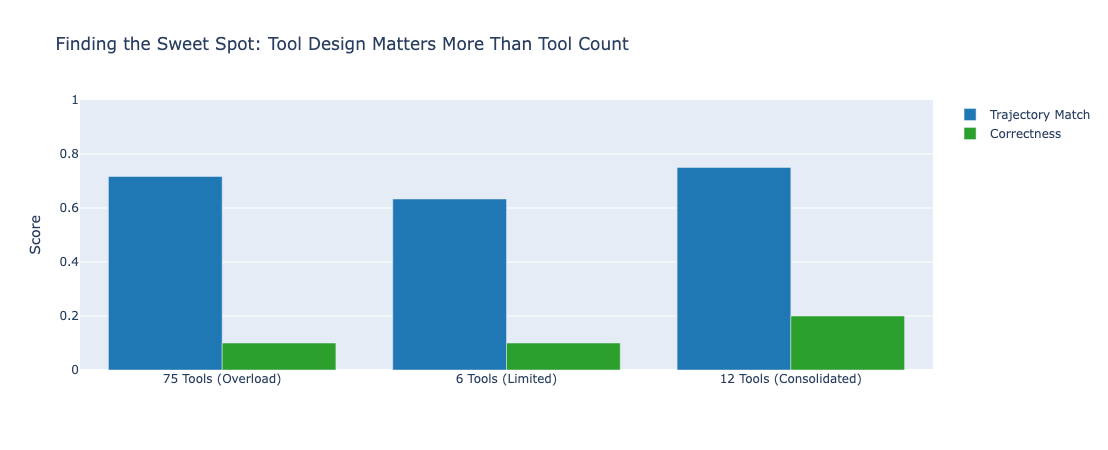

,Configuration,Tool Count,Trajectory Match,Correctness,Tool Efficiency
0,75 Tools\n(Overload),75,71.7%,10.0%,1.09
1,6 Tools\n(Limited),6,63.3%,10.0%,1.60
2,12 Tools\n(Consolidated),12,75.0%,20.0%,1.20



📊 Key Findings:
   75 tools: 71.7% trajectory match, 10.0% correctness
   6 tools:  63.3% trajectory match, 10.0% correctness
   12 tools: 75.0% trajectory match, 20.0% correctness

 Sweet Spot Achieved:
   The 12 consolidated tools outperform both extremes by using flexible parameters
   instead of either too many specific tools or too few limited tools.


In [26]:
# Comparison visualization showing U-curve
configs = ["75 Tools\n(Overload)", "6 Tools\n(Limited)", "12 Tools\n(Consolidated)"]
trajectory_scores = [
    production_metrics["trajectory_match"],
    minimal_metrics["trajectory_match"],
    optimal_metrics["trajectory_match"]
]
correctness_scores = [
    production_metrics["correctness"],
    minimal_metrics["correctness"],
    optimal_metrics["correctness"]
]
efficiency_scores = [
    production_metrics["tool_efficiency"],
    minimal_metrics["tool_efficiency"],
    optimal_metrics["tool_efficiency"]
]

# Create grouped bar chart
fig = go.Figure()
fig.add_trace(go.Bar(
    name='Trajectory Match',
    x=configs,
    y=trajectory_scores,
    marker_color='#1f77b4'
))
fig.add_trace(go.Bar(
    name='Correctness',
    x=configs,
    y=correctness_scores,
    marker_color='#2ca02c'
))

fig.update_layout(
    title="Finding the Sweet Spot: Tool Design Matters More Than Tool Count",
    yaxis_title="Score",
    barmode='group',
    height=450,
    showlegend=True,
    yaxis=dict(range=[0, 1.0])
)

fig.show()

# Create summary table
comparison_df = pd.DataFrame({
    "Configuration": configs,
    "Tool Count": [len(all_tools), 6, 12],
    "Trajectory Match": [f"{s:.1%}" for s in trajectory_scores],
    "Correctness": [f"{s:.1%}" for s in correctness_scores],
    "Tool Efficiency": [f"{s:.2f}" for s in efficiency_scores],
})

display(comparison_df)

print("\n📊 Key Findings:")
print(f"   75 tools: {trajectory_scores[0]:.1%} trajectory match, {correctness_scores[0]:.1%} correctness")
print(f"   6 tools:  {trajectory_scores[1]:.1%} trajectory match, {correctness_scores[1]:.1%} correctness")
print(f"   12 tools: {trajectory_scores[2]:.1%} trajectory match, {correctness_scores[2]:.1%} correctness")
print("\n Sweet Spot Achieved:")
print("   The 12 consolidated tools outperform both extremes by using flexible parameters")
print("   instead of either too many specific tools or too few limited tools.")


**LangSmith shows us:** Fewer, focused tools perform better than many scattered tools.


In [22]:
# Consolidated tool dataset - same queries, slightly different expected trajectory
consolidated_dataset_name = "shipping-support-queries-consolidated"

test_cases_consolidated = [
    {
        "query": "I'm user@example.com, what's the status of order #84721?",
        "final_response": "Order #84721 is currently in transit.",
        "trajectory": [
            {"tool": "get_customer_by_email", "args": {"email": "user@example.com"}},
            {"tool": "get_order_info", "args": {"order_id": "84721", "include": ["status"]}}
        ],
        "success_criteria": "Should return order status: IN_TRANSIT"
    },
    {
        "query": "Track order 99002",
        "final_response": "Order #99002 has been delivered successfully.",
        "trajectory": [
            {"tool": "get_order_info", "args": {"order_id": "99002", "include": ["status", "shipment"]}}
        ],
        "success_criteria": "Should show DELIVERED status"
    },
    {
        "query": "I'm buyer@uk-shop.co.uk, why is order #23456 delayed?",
        "final_response": "Order #23456 is experiencing a customs delay.",
        "trajectory": [
            {"tool": "get_customer_by_email", "args": {"email": "buyer@uk-shop.co.uk"}},
            {"tool": "get_order_info", "args": {"order_id": "23456", "include": ["status", "shipment"]}}
        ],
        "success_criteria": "Should mention customs delay"
    },
    {
        "query": "I'm ops@widget.io and I need urgent help with order #10015",
        "final_response": "As a platinum tier customer, I'll prioritize your request for order #10015.",
        "trajectory": [
            {"tool": "get_customer_by_email", "args": {"email": "ops@widget.io"}},
            {"tool": "get_order_info", "args": {"order_id": "10015", "include": ["status", "customer"]}}
        ],
        "success_criteria": "Should recognize platinum tier customer"
    },
    {
        "query": "What's the tracking number for order 84721?",
        "final_response": "The tracking number for order #84721 is TRK84721ABC.",
        "trajectory": [
            {"tool": "get_order_info", "args": {"order_id": "84721", "include": ["tracking"]}}
        ],
        "success_criteria": "Should return tracking number"
    },
    {
        "query": "When will order #98765 arrive?",
        "final_response": "Order #98765 is estimated to arrive on March 20, 2024.",
        "trajectory": [
            {"tool": "get_order_info", "args": {"order_id": "98765", "include": ["shipment"]}}
        ],
        "success_criteria": "Should provide ETA date"
    },
    {
        "query": "I'm manager@euro-corp.eu, can you tell me about order #45678?",
        "final_response": "Order #45678 status available. Please note EU privacy requirements.",
        "trajectory": [
            {"tool": "get_customer_by_email", "args": {"email": "manager@euro-corp.eu"}},
            {"tool": "get_order_info", "args": {"order_id": "45678", "include": ["status", "customer"]}}
        ],
        "success_criteria": "Should note EU customer privacy"
    },
    {
        "query": "Show me the delivery history for order 84721",
        "final_response": "Order #84721 delivery history shows multiple scan events.",
        "trajectory": [
            {"tool": "get_order_info", "args": {"order_id": "84721", "include": ["tracking", "events"]}}
        ],
        "success_criteria": "Should show scan history"
    },
    {
        "query": "What carrier is handling order #23456?",
        "final_response": "Order #23456 is being shipped by Royal Mail.",
        "trajectory": [
            {"tool": "get_order_info", "args": {"order_id": "23456", "include": ["shipment"]}}
        ],
        "success_criteria": "Should return carrier: Royal Mail"
    },
    {
        "query": "Has order #11111 been delivered?",
        "final_response": "Order #11111 has been returned.",
        "trajectory": [
            {"tool": "get_order_info", "args": {"order_id": "11111", "include": ["status"]}}
        ],
        "success_criteria": "Should return status: RETURNED"
    },
]

# Create consolidated dataset - force recreate to ensure correct structure
try:
    existing = client.read_dataset(dataset_name=consolidated_dataset_name)
    client.delete_dataset(dataset_id=existing.id)
    print(f"✓ Deleted old consolidated dataset")
except:
    pass

consolidated_dataset = client.create_dataset(
    dataset_name=consolidated_dataset_name,
    description="Test queries with consolidated tool references"
)
for case in test_cases_consolidated:
    client.create_example(
        inputs={"query": case["query"]},
        outputs={
            "final_response": case["final_response"],
            "trajectory": case["trajectory"],
            "success_criteria": case["success_criteria"]
        },
        dataset_id=consolidated_dataset.id
    )
print(f"✓ Created consolidated dataset with {len(test_cases_consolidated)} examples")
print(f"   View dataset: https://smith.langchain.com/o/{client._get_tenant_id()}/datasets/{consolidated_dataset.id}")



✓ Created consolidated dataset with 10 examples
   View dataset: https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/b1098be1-00e2-4fd9-8527-8e247a82ad1e


---

## Problem 2: Irrelevant Tools Cause Distraction

**Hypothesis:** It's not just quantity - irrelevant tools are the real problem.

Test different ratios of relevant:irrelevant tools (total ~20).


In [ ]:
# Create noise ratio configurations
noise_configs = [
    {"name": "100-pct-relevant", "tools": shipping_core_tools + carrier_tools + returns_tools + warehouse_tools[:2]},
    {"name": "75-pct-relevant", "tools": shipping_core_tools + carrier_tools + returns_tools + fraud_tools[:3]},
    {"name": "50-pct-relevant", "tools": shipping_core_tools + carrier_tools + analytics_tools + marketing_tools[:4]},
    {"name": "25-pct-relevant", "tools": shipping_core_tools + fraud_tools + analytics_tools + marketing_tools + vendor_tools[:2]},
]

print("Noise ratio configurations:")
for config in noise_configs:
    print(f"  {config['name']}: {len(config['tools'])} total tools")

# Run experiments
for config in noise_configs:
    print(f"\nTesting {config['name']}...")
    
    agent = create_agent(
        model=llm,
        tools=config["tools"],
        system_prompt=SHIPPING_SUPPORT_INSTRUCTIONS
    )
    
    evaluate(
        lambda inputs: run_agent_with_trajectory(agent, inputs["query"]),
        data=dataset_name,
        evaluators=ALL_EVALUATORS,
        experiment_prefix=f"noise-{config['name']}",
        metadata={"config": config["name"]},
    )
    
    print(f"  ✓ Complete")

print("\n✓ All noise ratio experiments complete!")


Noise ratio configurations:
  100-pct-relevant: 15 total tools
  75-pct-relevant: 16 total tools
  50-pct-relevant: 15 total tools
  25-pct-relevant: 17 total tools

Testing 100-pct-relevant...
View the evaluation results for experiment: 'noise-100-pct-relevant-cc1e806c' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/f1c40220-8838-47f6-99a9-e53926f5abf7/compare?selectedSessions=5f5c6e83-351f-4e56-b2d7-5c457541e91b




0it [00:00, ?it/s]

  ✓ Complete

Testing 75-pct-relevant...


### Analyzing the Impact of Irrelevant Tools

Let's extract and visualize the results to see how noise affects performance:


In [ ]:
# Extract metrics from noise ratio experiments
noise_percentages = [100, 75, 50, 25]
noise_configs_names = ["100-pct-relevant", "75-pct-relevant", "50-pct-relevant", "25-pct-relevant"]

relevance_by_noise = []
unnecessary_by_noise = []

for config_name in noise_configs_names:
    exp_name = f"noise-{config_name}"
    metrics = extract_metrics_from_experiment(exp_name)
    relevance_by_noise.append(metrics.get("trajectory_match", 0))
    unnecessary_by_noise.append(metrics.get("correctness", 0))

# Visualize the impact
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=noise_percentages,
    y=relevance_by_noise,
    mode='lines+markers',
    name='Trajectory Match',
    line=dict(color='#1f77b4', width=3),
    marker=dict(size=10)
))
fig.add_trace(go.Scatter(
    x=noise_percentages,
    y=unnecessary_by_noise,
    mode='lines+markers',
    name='Correctness',
    line=dict(color='#2ca02c', width=3),
    marker=dict(size=10),
    yaxis='y2'
))

fig.update_layout(
    title="Impact of Irrelevant Tools on Agent Performance",
    xaxis_title="% Relevant Tools",
    yaxis_title="Trajectory Match Score",
    yaxis2=dict(
        title="Correctness Score",
        overlaying='y',
        side='right'
    ),
    hovermode='x unified',
    height=400
)

fig.show()

# Create comparison table
noise_comparison = {
    "% Relevant": noise_percentages,
    "Trajectory Match": relevance_by_noise if relevance_by_noise[0] > 0 else ["Run eval"] * 4,
    "Correctness": unnecessary_by_noise if unnecessary_by_noise[0] > 0 else ["Run eval"] * 4,
}

df_noise = pd.DataFrame(noise_comparison)
display(df_noise)

print("\n📊 Key Findings:")
if relevance_by_noise[0] > 0:
    print(f"   100% relevant tools: {relevance_by_noise[0]:.2f} trajectory match, {unnecessary_by_noise[0]:.2f} correctness")
    print(f"   25% relevant tools: {relevance_by_noise[3]:.2f} trajectory match, {unnecessary_by_noise[3]:.2f} correctness")
    degradation = ((relevance_by_noise[0] - relevance_by_noise[3]) / relevance_by_noise[0] * 100) if relevance_by_noise[0] > 0 else 0
    print(f"   Degradation: {degradation:.0f}% drop in trajectory match")
else:
    print("   Run evaluations above to see actual metrics")
print("   - Even with constant tool count (~20), noise degrades performance")
print("   - Irrelevant tools lead to incorrect tool calls")
print("   - Quality of tools matters as much as quantity")


---

## Solution 2: Smart Tool Filtering with Routing

**Insight:** Classify query intent, then provide only relevant tools.


In [ ]:
# Simple query router
def classify_query_intent(query: str) -> Literal["shipping", "returns", "billing", "warehouse"]:
    """Classify intent - in production use an LLM."""
    query_lower = query.lower()
    
    if any(word in query_lower for word in ["return", "refund", "send back"]):
        return "returns"
    elif any(word in query_lower for word in ["bill", "charge", "payment"]):
        return "billing"
    elif any(word in query_lower for word in ["stock", "inventory", "warehouse"]):
        return "warehouse"
    else:
        return "shipping"

def get_tools_for_intent(intent: str) -> list:
    """Return tools for intent."""
    if intent == "shipping":
        return shipping_core_tools + carrier_tools
    elif intent == "returns":
        return shipping_core_tools + returns_tools
    elif intent == "billing":
        return shipping_core_tools + billing_tools
    elif intent == "warehouse":
        return shipping_core_tools + warehouse_tools
    return shipping_core_tools

print("✓ Created intent-based router")

# Test routed agent
def run_routed_agent_with_trajectory(inputs: dict) -> dict:
    """Run routed agent with intent-based tool selection and return structured output."""
    query = inputs["query"]
    intent = classify_query_intent(query)
    tools = get_tools_for_intent(intent)
    
    agent = create_agent(
        model=llm,
        tools=tools,
        system_prompt=SHIPPING_SUPPORT_INSTRUCTIONS
    )
    
    return run_agent_with_trajectory(agent, query)

routed_results = evaluate(
    run_routed_agent_with_trajectory,
    data=dataset_name,
    evaluators=ALL_EVALUATORS,
    experiment_prefix="solution-routed",
    metadata={"config": "routed"},
)

print(f"\n✓ Routed agent evaluation complete!")


### Comparing Routing vs Noise

How does smart routing compare to the worst-case noise scenario?


In [ ]:
# Compare routing solution vs worst noise configuration
try:
    worst_noise_metrics = extract_metrics_from_experiment("noise-25-pct-relevant")
    routed_metrics = extract_metrics_from_experiment("solution-routed")
    
    routing_comparison = {
        "Configuration": ["25% Relevant Tools (No Routing)", "Smart Routing"],
        "Trajectory Match": [worst_noise_metrics.get("trajectory_match", 0), routed_metrics.get("trajectory_match", 0)],
        "Correctness": [worst_noise_metrics.get("correctness", 0), routed_metrics.get("correctness", 0)],
        "Tool Efficiency": [worst_noise_metrics.get("tool_efficiency", 0), routed_metrics.get("tool_efficiency", 0)],
    }
    
    # Create bar chart comparison
    df_routing = pd.DataFrame(routing_comparison)
    
    fig = go.Figure()
    fig.add_trace(go.Bar(
        name='25% Relevant (No Routing)',
        x=['Trajectory Match', 'Correctness'],
        y=[worst_noise_metrics.get("trajectory_match", 0), worst_noise_metrics.get("correctness", 0)],
        marker_color='#d62728'
    ))
    fig.add_trace(go.Bar(
        name='Smart Routing',
        x=['Trajectory Match', 'Correctness'],
        y=[routed_metrics.get("trajectory_match", 0), routed_metrics.get("correctness", 0)],
        marker_color='#2ca02c'
    ))
    
    fig.update_layout(
        title="Routing Solution vs Worst Noise Configuration",
        yaxis_title="Score",
        barmode='group',
        height=400
    )
    
    fig.show()
    
    display(df_routing)
    
    print("\n✅ Smart routing eliminates noise:")
    if routed_metrics.get("trajectory_match", 0) > 0:
        improvement = ((routed_metrics.get("trajectory_match", 0) - worst_noise_metrics.get("trajectory_match", 0)) / worst_noise_metrics.get("trajectory_match", 1) * 100) if worst_noise_metrics.get("trajectory_match", 0) > 0 else 0
        print(f"   Trajectory match improvement: {improvement:.0f}%")
        print(f"   Correctness improved from {worst_noise_metrics.get('correctness', 0):.2f} to {routed_metrics.get('correctness', 0):.2f}")
    else:
        print("   Run evaluations above to see actual metrics")
    print("   - Intent classification filters out irrelevant tool domains")
    print("   - Agent sees only tools needed for the query type")
    print("   - Maintains performance by keeping context focused")
    
except Exception as e:
    print(f"Run the evaluations above first to see comparison. Error: {e}")
    routing_comparison = {
        "Configuration": ["25% Relevant Tools (No Routing)", "Smart Routing"],
        "Trajectory Match": ["Run eval", "Run eval"],
        "Correctness": ["Run eval", "Run eval"],
        "Tool Efficiency": ["Run eval", "Run eval"],
    }
    df_routing = pd.DataFrame(routing_comparison)
    display(df_routing)


---

## Problem 3: Instruction Bloat Hurts Too

**Hypothesis:** Verbose instructions degrade performance.

Add evaluator to check instruction following:


In [ ]:
# Expected tools checker is now replaced by trajectory_match_evaluator


In [ ]:
# Test with bloated instructions
clean_instructions = f"{SHIPPING_SUPPORT_INSTRUCTIONS}\n\n{CARRIER_MANAGEMENT_INSTRUCTIONS}"
noisy_instructions = f"{clean_instructions}\n\n{IRRELEVANT_INSTRUCTIONS}"

print(f"Clean: {len(clean_instructions):,} chars")
print(f"Noisy: {len(noisy_instructions):,} chars")
print(f"Bloat: {len(noisy_instructions) / len(clean_instructions):.1f}x")

noisy_agent = create_agent(
    model=llm,
    tools=shipping_core_tools,
    system_prompt=noisy_instructions
)

evaluate(
    lambda inputs: run_agent_with_trajectory(noisy_agent, inputs["query"]),
    data=dataset_name,
    evaluators=ALL_EVALUATORS,
    experiment_prefix="problem-noisy-instructions",
    metadata={"tool_count": 6, "instruction_length": len(noisy_instructions)},
)

print("✓ Evaluation complete!")


### Analyzing Instruction Bloat Impact

Let's see how extra instructions affected performance:


In [ ]:
# Extract and compare instruction bloat impact
try:
    clean_baseline_metrics = extract_metrics_from_experiment("scaling-6-tools")
    bloated_metrics = extract_metrics_from_experiment("problem-noisy-instructions")
    
    # Create comparison visualization
    metrics_to_compare = ['Trajectory Match', 'Correctness', 'Tool Efficiency']
    clean_scores = [
        clean_baseline_metrics.get("trajectory_match", 0),
        clean_baseline_metrics.get("correctness", 0),
        clean_baseline_metrics.get("tool_efficiency", 1.0)  # Baseline expected to be 1.0
    ]
    bloated_scores = [
        bloated_metrics.get("trajectory_match", 0),
        bloated_metrics.get("correctness", 0),
        bloated_metrics.get("tool_efficiency", 0)
    ]
    
    fig = go.Figure()
    fig.add_trace(go.Bar(
        name='Clean Instructions',
        x=metrics_to_compare,
        y=clean_scores,
        marker_color='#2ca02c'
    ))
    fig.add_trace(go.Bar(
        name='Bloated Instructions',
        x=metrics_to_compare,
        y=bloated_scores,
        marker_color='#d62728'
    ))
    
    fig.update_layout(
        title="Impact of Instruction Bloat on Agent Performance",
        yaxis_title="Score",
        barmode='group',
        height=400
    )
    
    fig.show()
    
    # Create comparison table
    instruction_impact = {
        "Metric": ["Trajectory Match", "Correctness", "Tool Efficiency"],
        "Clean Instructions": [
            f"{clean_baseline_metrics.get('trajectory_match', 0):.2f}",
            f"{clean_baseline_metrics.get('correctness', 0):.2f}",
            f"{clean_baseline_metrics.get('tool_efficiency', 1.0):.2f}"
        ],
        "Bloated Instructions": [
            f"{bloated_metrics.get('trajectory_match', 0):.2f}",
            f"{bloated_metrics.get('correctness', 0):.2f}",
            f"{bloated_metrics.get('tool_efficiency', 0):.2f}"
        ]
    }
    
    df_instructions = pd.DataFrame(instruction_impact)
    display(df_instructions)
    
    print("\n📉 Key Findings on Instruction Bloat:")
    if bloated_metrics.get("trajectory_match", 0) > 0:
        traj_drop = ((clean_baseline_metrics.get("trajectory_match", 0) - bloated_metrics.get("trajectory_match", 0)) / clean_baseline_metrics.get("trajectory_match", 1) * 100) if clean_baseline_metrics.get("trajectory_match", 0) > 0 else 0
        corr_drop = ((clean_baseline_metrics.get("correctness", 0) - bloated_metrics.get("correctness", 0)) / clean_baseline_metrics.get("correctness", 1) * 100) if clean_baseline_metrics.get("correctness", 0) > 0 else 0
        print(f"   Trajectory match degraded by {traj_drop:.0f}%")
        print(f"   Correctness degraded by {corr_drop:.0f}%")
        print(f"   Tool efficiency: {bloated_metrics.get('tool_efficiency', 0):.2f}")
    else:
        print("   Run evaluations above to see actual metrics")
    print("   - Extra instructions from irrelevant domains confuse the agent")
    print("   - Agent may miss obvious tool choices")
    print("   - Focused instructions lead to better tool selection")
    
except Exception as e:
    print(f"Run the evaluations above first to see comparison. Error: {e}")
    instruction_impact = {
        "Metric": ["Trajectory Match", "Correctness", "Tool Efficiency"],
        "Clean Instructions": ["Run eval", "Run eval", "Run eval"],
        "Bloated Instructions": ["Run eval", "Run eval", "Run eval"]
    }
    df_instructions = pd.DataFrame(instruction_impact)
    display(df_instructions)


---

## Solution 3: Instruction Pruning

**Insight:** Keep only essential instructions. LangSmith A/B testing validates.


In [ ]:
# Extract and compare
try:
    clean_metrics = extract_metrics_from_experiment("scaling-6-tools")
    noisy_metrics = extract_metrics_from_experiment("problem-noisy-instructions")
    
    instruction_comparison = {
        "Instructions": ["Clean (focused)", "Bloated (all domains)"],
        "Tool Count": [6, 6],
        "Trajectory Match": [clean_metrics.get("trajectory_match", 0), noisy_metrics.get("trajectory_match", 0)],
        "Correctness": [clean_metrics.get("correctness", 0), noisy_metrics.get("correctness", 0)],
    }
except:
    instruction_comparison = {
        "Instructions": ["Clean (focused)", "Bloated (all domains)"],
        "Tool Count": [6, 6],
        "Trajectory Match": ["Run eval", "Run eval"],
        "Correctness": ["Run eval", "Run eval"],
    }

df_instructions = pd.DataFrame(instruction_comparison)
display(df_instructions)

print("\n✅ Minimal instructions maintain or improve performance")
print("   - LangSmith A/B testing validates focused instructions")


---

## Key Takeaways

### The Sweet Spot Is Real

Our experiments demonstrate a clear U-curve:

- **75 tools (overload):** Context confusion from overlapping choices leads to poor performance
- **6 tools (minimal):** Over-correction leaves gaps - can't handle all query types
- **12 tools (consolidated):** Sweet spot with flexible parameters delivers full capability AND clarity

**The winning approach:** Intelligent consolidation at the right level of abstraction.

### What Makes Consolidated Tools Work

1. **Flexible parameters over many specific tools** - One `get_order_info` with `include` parameter beats five separate getter functions

2. **Reduces cognitive load** - 12 well-designed tools are easier to navigate than 75 overlapping options

3. **Maintains full capability** - Parameter-based design covers all use cases without sacrificing functionality

4. **Measurable with LangSmith** - Custom evaluators (trajectory match, correctness, efficiency) quantify the improvement

### Professional Implementation Strategy

When facing context confusion in production:

1. **Start with measurement** - Use LangSmith to quantify the problem (don't guess)
2. **Identify tool clusters** - Group tools that serve similar purposes
3. **Design consolidated versions** - Add parameters for flexibility instead of creating new tools
4. **Validate with evals** - Ensure consolidated tools match or exceed original performance
5. **Iterate to sweet spot** - Find the balance between too many and too few

### Real-World Impact

By finding the sweet spot:
- **Better performance** - Higher accuracy, fewer mistakes from tool confusion
- **Lower costs** - Fewer tokens in context, faster inference
- **Easier maintenance** - Consolidated, well-organized toolsets
- **Better UX** - Faster, more accurate responses for users
- **Scalable** - Room to add capabilities without degrading performance

---

**Context confusion isn't solved by minimalism - it's solved by intelligent design. Use LangSmith to measure, then optimize to your sweet spot.**
